In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


# Load data
df = pd.read_csv('../../data/kaggle_20m/movie_genres_ratings.csv')

# Splitting features and target variable
X = df.drop(columns=['movieId', 'title', 'rating'])
y = df['rating']

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [2]:
# Convert data to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train.values)
y_train_tensor = torch.FloatTensor(y_train.values).view(-1, 1)
X_test_tensor = torch.FloatTensor(X_test.values)
y_test_tensor = torch.FloatTensor(y_test.values).view(-1, 1)

# Create DataLoader objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=32)

In [3]:
# Define the MLP model with dropout and batch normalization
class RobustMLP(nn.Module):
    def __init__(self, input_dim):
        super(RobustMLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.dropout2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)

        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)

        return self.fc3(x)

In [4]:
# Initialize the model
input_dim = X_train.shape[1]
model = RobustMLP(input_dim)

# Loss and optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# Training loop with early stopping
num_epochs = 50
best_loss = float('inf')
train_losses = []
test_losses = []
train_rmse = []
train_maes = []
test_maes = []
train_mses = []
test_mses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_losses = []
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        epoch_train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

    avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
    train_losses.append(avg_train_loss)

    train_mae = torch.mean(torch.abs(outputs - target)).item()
    epoch_train_rmse = torch.sqrt(torch.tensor(avg_train_loss)).item() # compute RMSE for this epoch
    train_rmse.append(epoch_train_rmse) # append it to the list
    train_maes.append(train_mae)
    train_mses.append(avg_train_loss)


    # Validation loss for early stopping
    model.eval()
    val_losses = []
    val_maes = []
    with torch.no_grad():
        for data, target in test_loader:
            outputs = model(data)
            val_losses.append(criterion(outputs, target).item())
            val_maes.append(torch.mean(torch.abs(outputs - target)).item())

    avg_val_loss = sum(val_losses) / len(val_losses)
    avg_val_mae = sum(val_maes) / len(val_maes)
    val_rmse = torch.sqrt(torch.tensor(avg_val_loss)).item()

    test_losses.append(avg_val_loss)
    test_maes.append(avg_val_mae)
    test_mses.append(avg_val_loss)

    # if (epoch+1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')
    #
    # # Early stopping
    # if avg_val_loss < best_loss:
    #     best_loss = avg_val_loss
    # else:
    #     print("Early stopping")
    #     break



In [5]:
# Evaluation metrics
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    mse = criterion(predictions, y_test_tensor).item()
    mae = torch.mean(torch.abs(predictions - y_test_tensor)).item()
    rmse = torch.sqrt(criterion(predictions, y_test_tensor)).item()

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test RMSE: {rmse:.4f}")

Test MSE: 0.3824
Test MAE: 0.4613
Test RMSE: 0.6184


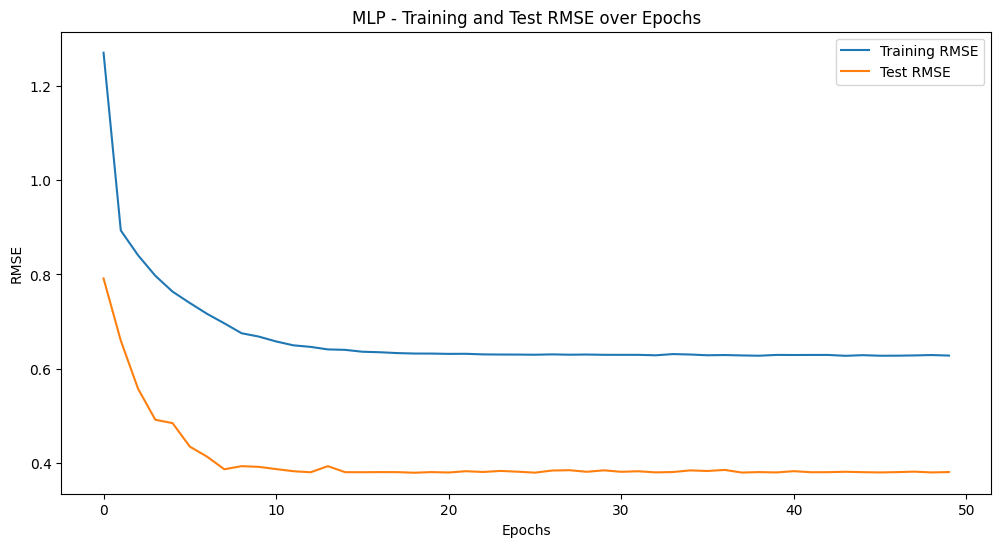

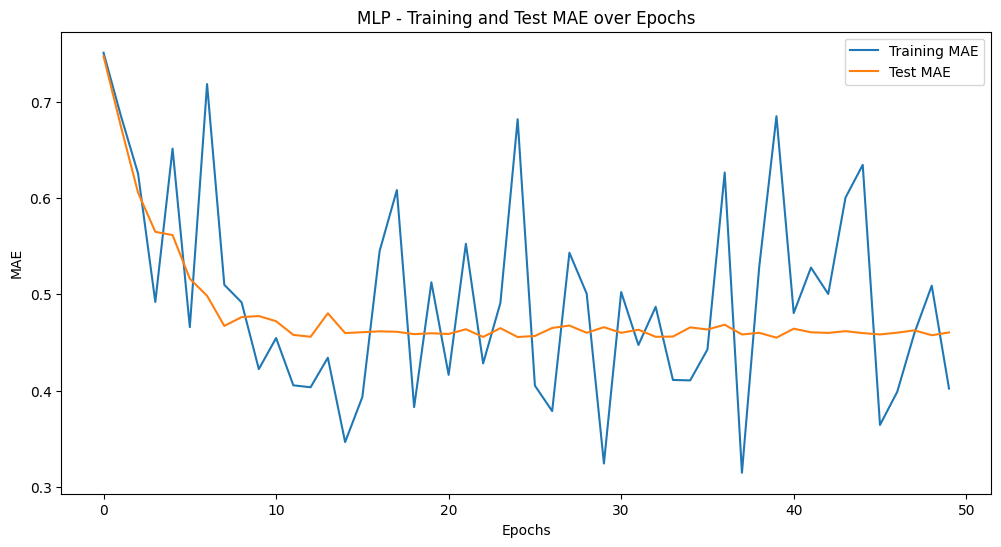

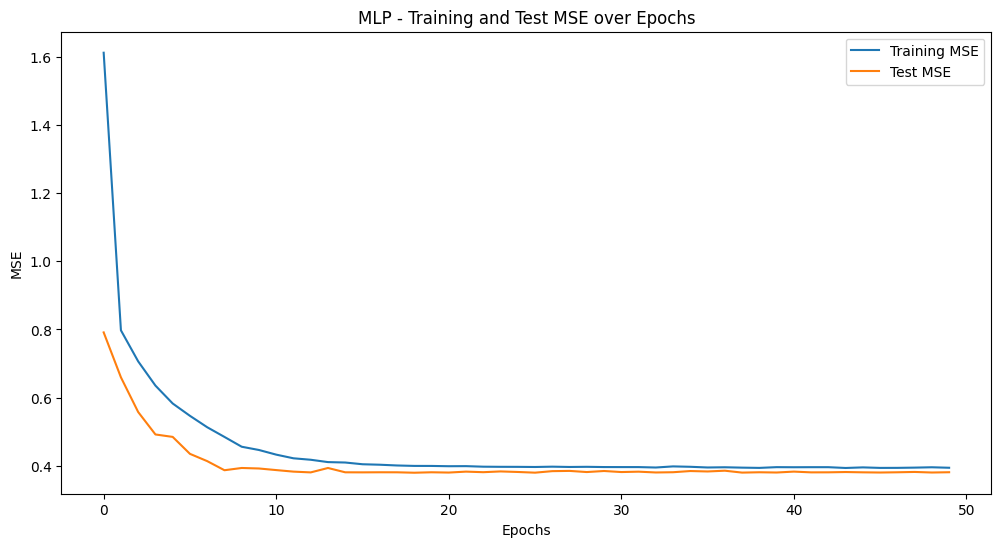

In [6]:
import matplotlib.pyplot as plt
import os

# Create folder if it doesn't exist
output_folder = "../../metrics/overleaf"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

model_name = "MLP"

# RMSE plot
# RMSE plot
plt.figure(figsize=(12, 6))
plt.plot(train_rmse, label='Training RMSE')
plt.plot(test_losses, label='Test RMSE')  # Note: test_losses holds RMSE values
# ... other code ...

plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.title(f'{model_name} - Training and Test RMSE over Epochs')
plt.savefig(os.path.join(output_folder, f'{model_name}_rmse_plot.png'))  # Save the figure
plt.show()

# MAE plot
plt.figure(figsize=(12, 6))
plt.plot(train_maes, label='Training MAE')
plt.plot(test_maes, label='Test MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.title(f'{model_name} - Training and Test MAE over Epochs')
plt.savefig(os.path.join(output_folder, f'{model_name}_mae_plot.png'))  # Save the figure
plt.show()

# MSE plot
plt.figure(figsize=(12, 6))
plt.plot(train_mses, label='Training MSE')
plt.plot(test_mses, label='Test MSE')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.legend()
plt.title(f'{model_name} - Training and Test MSE over Epochs')
plt.savefig(os.path.join(output_folder, f'{model_name}_mse_plot.png'))  # Save the figure
plt.show()